In [1]:
!pip install wget
!pip install spacy_langdetect
!pip install clean-text

import os
import re
import wget
import spacy
import zipfile
import gzip
import json


import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download("punkt")
from nltk.tokenize import word_tokenize
from spacy_langdetect import LanguageDetector
from cleantext import clean

import time
import random
import numpy as np
import pandas as pd
import collections
from spacy.tokens import Doc

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

"""
Ignoring FutureWarning
"""
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ImportWarning)


  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=315e72241a110ec8b006b2365c1fd3bb2ad4b7d0009e99503cd633582d8ceede
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 1.0MB 7.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993461 sha256=fea3cb01859133969c69025e93eedeca21cd25f3d2a579679358c5361dc131bb
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
     |████████████████████████████████| 71kB 6.1MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45612 sha256=5e35ba0c7d070fe1cc96109e59fe35140c26a7be08c3a410127c83ace56ed991
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ftfy
[nltk_data] Downloading package stopwords t

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("/content/gdrive/",force_remount=True)

Mounted at /content/gdrive/


### **Constants And Required Functions**

**Data Preprocessing**

In [3]:
NO_ANSWER_PRESENT = "no answer present"

def textPreprocess(txt):
    """
    Convert to Lowercase and Trim the text
    """
    txt = txt.lower().strip()

    """
    Fix various unicode errors
    transliterate to closest ASCII representation
    """
    txt = clean(txt, fix_unicode=True, to_ascii=True)

    """
    Removing zero-width character
    """
    txt = re.sub(u"\ufe0f", r" ", txt)

    """
    Remove URL
    """
    txt = re.sub(r"https?://[A-Za-z0-9./]*", r" ", txt)

    """
    Remove Specific Special character
    """
    txt = re.sub(r"[-.!?()_]+", r" ", txt)
    """
    Remove charatcter like special characters, punctuations except alphanumeric charatcter.
    """
    txt = re.sub(r"[^0-9a-zA-Z]+", r" ", txt)

    """
    Remove Extra spaces which are appearing from previous processing steps.
    """
    txt = re.sub(r"\s+", r" ", txt).strip()
    return txt


**Required Directories Creation**

In [4]:
"""
Required functions for directory creation
"""
def check_if_dir_exists(directory):
    """
    Checks if 'directory' exists
    """
    return(os.path.isdir(directory))

def make_dir(directory):
    """
    Create directory
    """
    if not check_if_dir_exists(directory):
        os.mkdir(directory)
        print("Directory %s created successfully." %directory)
    else:
        print("Directory %s exists." %directory)

print("We are in:",os.getcwd())

"""
Required directory creation
"""
chatbot_dir="/content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta"
make_dir(chatbot_dir)

os.chdir("/content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta")

chatbot_data_dir = chatbot_dir + "/ChatBot_Data/"
make_dir(chatbot_data_dir)

chatbot_result_dir = chatbot_dir + "/ChatBot_Results/"
make_dir(chatbot_result_dir)

chatbot_checkpoint_dir = chatbot_dir + "/ChatBot_Checkpoint/"
make_dir(chatbot_checkpoint_dir)

print(chatbot_data_dir)

We are in: /content
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta created successfully.
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/ created successfully.
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Results/ created successfully.
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Checkpoint/ created successfully.
/content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/


**Dataset Download and Extraction**

In [5]:
"""
Required functions for dataset download and extraction
"""
def check_if_file_exists(file):
    """
    Checks if 'file' exists
    """
    return os.path.isfile(file)


def download_dataset(data_source_url, data_file_path, data_folder_path):
    """
    Download the dataset
    """
    if not check_if_file_exists(data_file_path):
        print("Start of data download")
        wget.download(url=data_source_url, out=data_folder_path)
        print("Download complete")
    else:
        print("Data file already exists. Not downloading again!")


def extract_gzip_file(extract_file, file_name):
    """
    Extract or unzip the downloaded the dataset
    """
    if not check_if_file_exists(extract_file):
        try:
            startTime = time.time()
            print("Extracting all the files now...") 
            file_to_extract = gzip.GzipFile(file_name, "rb")
            read_obj = file_to_extract.read()
            file_to_extract.close()

            output = open(extract_file, "wb")
            output.write(read_obj)
            output.close()
            print("Done!") 
            total_time = time.time()-startTime
            print("Time Taken for extracting all files :", total_time/60," minutes")
        except FileNotFoundError:
            print("Please make sure file: " + file_name + " is present before continuing")
    else:
        print("Data file ", extract_file, "exists.\nWon\'t extract again!")

"""
Download and Extract Dataset 
"""

"""
Data source url
"""
data_source_url="https://msmarco.blob.core.windows.net/msmarco/dev_v2.1.json.gz"
print('Data source url :',data_source_url)

loaded_data = {}

"""
Download Dataset 
"""
tar_file = data_source_url.split("/")[-1]
extract_file_path = chatbot_data_dir + tar_file[:-3]
data_file_path = chatbot_data_dir + tar_file
print("extract_file_path : ", chatbot_data_dir + tar_file[:-3])
print("data_file_path : ", data_file_path)
print("chatbot_data_dir : ", chatbot_data_dir)

download_dataset(data_source_url, data_file_path, chatbot_data_dir)    

"""
Extract the downloaded dataset
"""
extract_gzip_file(extract_file_path, data_file_path)

"""
Read json data in file
"""
loaded_data[tar_file[:-8]] = json.loads(open(extract_file_path,'r').read())

Data source url : https://msmarco.blob.core.windows.net/msmarco/dev_v2.1.json.gz
extract_file_path :  /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/dev_v2.1.json
data_file_path :  /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/dev_v2.1.json.gz
chatbot_data_dir :  /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/
Start of data download
Download complete
Extracting all the files now...
Done!
Time Taken for extracting all files : 0.07630562782287598  minutes


**Listing Directories**

In [6]:
def list_dir(dir_path):
  """
  List directories for a given path
  """
  print("Directory %s contains : " %dir_path)
  for dir_or_file in os.listdir(dir_path):
    print(dir_or_file)
  print("\n")

"""
List created directories
"""
print("Current directory : ", os.getcwd(),"\n")
list_dir(chatbot_dir)
list_dir(chatbot_data_dir)
list_dir(chatbot_checkpoint_dir)

Current directory :  /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta 

Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta contains : 
ChatBot_Data
ChatBot_Results
ChatBot_Checkpoint


Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/ contains : 
dev_v2.1.json.gz
dev_v2.1.json


Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Checkpoint/ contains : 




**Data Preprocesssing or Transformation**

In [7]:
def extract_data(data_file_key):
    data_dict = {}
    multiple_answer_count=0
    multiple_well_formed_answer_count=0

    for key, value in loaded_data[data_file_key]["query_id"].items():
        data_dict[str(key)] = {}
        data_dict[str(key)]["query_id"] = value

    for key, value in loaded_data[data_file_key]["answers"].items():
        """
        Take the first answer in answers
        """
        data_dict[str(key)]["answer"] = textPreprocess(value[0])
        
        if len(value) > 1:
            multiple_answer_count+=1

    for key, value in loaded_data[data_file_key]["passages"].items():
        data_dict[str(key)]["passages"] = value

    for key, value in loaded_data[data_file_key]["query"].items():
        data_dict[str(key)]["question"] = textPreprocess(value)

    for key, value in loaded_data[data_file_key]["query_type"].items():
        data_dict[str(key)]["query_type"] = value

    for key, value in loaded_data[data_file_key]["wellFormedAnswers"].items():
        """
        Take the first answer in wellFormedAnswers
        """

        if isinstance(value, list):
            data_dict[str(key)]["wellFormedAnswer"] = textPreprocess(value[0]) 

            if len(value) > 1:
                multiple_well_formed_answer_count+=1  

        else:
            data_dict[str(key)]["wellFormedAnswer"] = NO_ANSWER_PRESENT

    data_list = []
    for key in data_dict.keys():
        data_list.append(data_dict[key])
    return data_list, multiple_answer_count, multiple_well_formed_answer_count

In [8]:
data_list, multiple_answer_count, multiple_well_formed_answer_count = extract_data(data_file_key="dev_v2.1")
data_df = pd.DataFrame(data_list)
print("Shape data_df : ",data_df.shape)
print("Shape data_df with None Null answer : ",data_df[(data_df['answer'] != "no answer present")].shape)
print("Shape data_df where Null Answere can be replaced by well formed answer : ", data_df[(data_df["answer"] == "no answer present") & (data_df['wellFormedAnswer'] != "no answer present")].shape)
data_df.head()

Shape data_df :  (101093, 6)
Shape data_df with None Null answer :  (55636, 6)
Shape data_df where Null Answere can be replaced by well formed answer :  (19, 6)


,query_id,answer,passages,question,query_type,wellFormedAnswer
0,1102432,a corporation is a company or group of people ...,"[{'is_selected': 0, 'passage_text': 'A company...",what is a corporation,DESCRIPTION,no answer present
1,1102431,rachel carson writes the obligation to endure ...,"[{'is_selected': 0, 'passage_text': 'Read to w...",why did rachel carson write an obligation to e...,DESCRIPTION,no answer present
2,1102421,no answer present,"[{'is_selected': 0, 'passage_text': 'The Progr...",why did the progressive movement fail to advan...,DESCRIPTION,no answer present
3,1102315,no answer present,"[{'is_selected': 0, 'passage_text': 'On an ave...",why do police need to understand what the fore...,DESCRIPTION,no answer present
4,1101280,no answer present,"[{'is_selected': 0, 'passage_text': 'A: Very, ...",do owls eat in the day,NUMERIC,no answer present


In [9]:
def getBestAnswere(cols):
  answer, wellFormedAnswer = str(cols[0]), str(cols[1])
  if wellFormedAnswer == "no answer present" and answer !="":
     answer =  answer
  else:
     answer = wellFormedAnswer
  return answer


data_df["answer"] = data_df[["answer", "wellFormedAnswer"]].apply(getBestAnswere, axis =1)
print("Before processing the shape data_df : ",data_df.shape)

qa_df= data_df[(data_df["answer"] != "no answer present")]

print("After processing the shape qa_df : ",qa_df.shape)
qa_df.head()

Before processing the shape data_df :  (101093, 6)
After processing the shape qa_df :  (55592, 6)


,query_id,answer,passages,question,query_type,wellFormedAnswer
0,1102432,a corporation is a company or group of people ...,"[{'is_selected': 0, 'passage_text': 'A company...",what is a corporation,DESCRIPTION,no answer present
1,1102431,rachel carson writes the obligation to endure ...,"[{'is_selected': 0, 'passage_text': 'Read to w...",why did rachel carson write an obligation to e...,DESCRIPTION,no answer present
5,1090282,the symptoms of a dying mouse are runny eyes s...,"[{'is_selected': 0, 'passage_text': 'This can ...",symptoms of a dying mouse,ENTITY,no answer present
6,39449,globally 8 640 000 lightning strikes per day,"[{'is_selected': 0, 'passage_text': 'Lightning...",average number of lightning strikes per day,NUMERIC,no answer present
7,76162,yes over fertilizing can burn lawn,"[{'is_selected': 0, 'passage_text': 'Verify th...",can you burn your lawn with fertilizer,DESCRIPTION,no answer present


In [10]:
qa_df["question_len"]= qa_df["question"].apply(len)
qa_df["answer_len"]= qa_df["answer"].apply(len)


qa_df["question_wrd_len"]= qa_df["question"].apply(lambda x: len(x.split( )))
qa_df["answer_wrd_len"]= qa_df["answer"].apply(lambda x: len(x.split( )))

print("qa_df[question_len].min() : ",qa_df["question_len"].min())
print("qa_df[aanswer_len].min() : ",qa_df["answer_len"].min())

print("qa_df[question_wrd_len].min() : ",qa_df["question_wrd_len"].min())
print("qa_df[answer_wrd_len].min() : ",qa_df["answer_wrd_len"].min())

qa_df[question_len].min() :  3
qa_df[aanswer_len].min() :  1
qa_df[question_wrd_len].min() :  1
qa_df[answer_wrd_len].min() :  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [11]:
qa_df[qa_df["question_len"]==3].head()

,query_id,answer,passages,question,query_type,wellFormedAnswer,question_len,answer_len,question_wrd_len,answer_wrd_len
10517,1100314,the gross domestic product is one of the prima...,"[{'is_selected': 0, 'passage_text': 'Nominal G...",gdp,NUMERIC,no answer present,3,107,1,20


In [12]:
print(qa_df[qa_df["answer_len"]==1].shape)

qa_df[qa_df["answer_len"]==1].head()

(8, 10)


,query_id,answer,passages,question,query_type,wellFormedAnswer,question_len,answer_len,question_wrd_len,answer_wrd_len
29117,60253,c,"[{'is_selected': 0, 'passage_text': '1 Calorie...",calories in egg,NUMERIC,c,15,1,3,1
41176,279367,3,"[{'is_selected': 1, 'passage_text': 'She has t...",how many children does jk rowling have,NUMERIC,no answer present,38,1,7,1
60005,287029,3,"[{'is_selected': 0, 'passage_text': 'Michael J...",how many kids does michael jordan has,NUMERIC,no answer present,37,1,7,1
68722,282264,4,"[{'is_selected': 0, 'passage_text': 'It's an i...",how many different blood groups are there,NUMERIC,no answer present,41,1,7,1
74800,933053,o,"[{'is_selected': 0, 'passage_text': 'Fully Dim...",what s the symbol for diminished chord,DESCRIPTION,no answer present,38,1,7,1


In [13]:
print(qa_df[qa_df["question_wrd_len"]==1].shape)
qa_df[qa_df["question_wrd_len"]==1].head()

(2, 10)


,query_id,answer,passages,question,query_type,wellFormedAnswer,question_len,answer_len,question_wrd_len,answer_wrd_len
10517,1100314,the gross domestic product is one of the prima...,"[{'is_selected': 0, 'passage_text': 'Nominal G...",gdp,NUMERIC,no answer present,3,107,1,20
68920,1724,it represents less than,"[{'is_selected': 1, 'passage_text': 'The great...",symbol,DESCRIPTION,no answer present,6,23,1,4


In [14]:
qa_df[qa_df['answer_wrd_len']==1].head()

,query_id,answer,passages,question,query_type,wellFormedAnswer,question_len,answer_len,question_wrd_len,answer_wrd_len
54,174249,yes,"[{'is_selected': 0, 'passage_text': 'How long ...",does xpress bet charge to deposit money in you...,DESCRIPTION,no answer present,55,3,10,1
159,76098,yes,"[{'is_selected': 0, 'passage_text': 'Some dogs...",can you break dogs chasing cars,DESCRIPTION,no answer present,31,3,6,1
243,70673,yes,"[{'is_selected': 1, 'passage_text': 'Confidenc...",can laser kill you,DESCRIPTION,no answer present,18,3,4,1
247,63343,yes,"[{'is_selected': 0, 'passage_text': 'In this c...",can a tenant in common sell their share,DESCRIPTION,no answer present,39,3,8,1
343,168353,yes,"[{'is_selected': 0, 'passage_text': 'I have ha...",does linzess work for constipation,DESCRIPTION,no answer present,34,3,5,1


In [15]:
qa_df = qa_df[(qa_df["question_wrd_len"] >= 2 ) & (qa_df["answer_wrd_len"] >= 2)]
print("Final Shape of Data: ",qa_df.shape)
qa_df.head()

Final Shape of Data:  (54167, 10)


,query_id,answer,passages,question,query_type,wellFormedAnswer,question_len,answer_len,question_wrd_len,answer_wrd_len
0,1102432,a corporation is a company or group of people ...,"[{'is_selected': 0, 'passage_text': 'A company...",what is a corporation,DESCRIPTION,no answer present,21,112,4,22
1,1102431,rachel carson writes the obligation to endure ...,"[{'is_selected': 0, 'passage_text': 'Read to w...",why did rachel carson write an obligation to e...,DESCRIPTION,no answer present,51,194,9,30
5,1090282,the symptoms of a dying mouse are runny eyes s...,"[{'is_selected': 0, 'passage_text': 'This can ...",symptoms of a dying mouse,ENTITY,no answer present,25,140,5,22
6,39449,globally 8 640 000 lightning strikes per day,"[{'is_selected': 0, 'passage_text': 'Lightning...",average number of lightning strikes per day,NUMERIC,no answer present,43,44,7,8
7,76162,yes over fertilizing can burn lawn,"[{'is_selected': 0, 'passage_text': 'Verify th...",can you burn your lawn with fertilizer,DESCRIPTION,no answer present,38,34,7,6


# **Exploratory Data Analysis**

In [16]:
sns.set_style("darkgrid")

**Distribution of Questions and Answers Length**

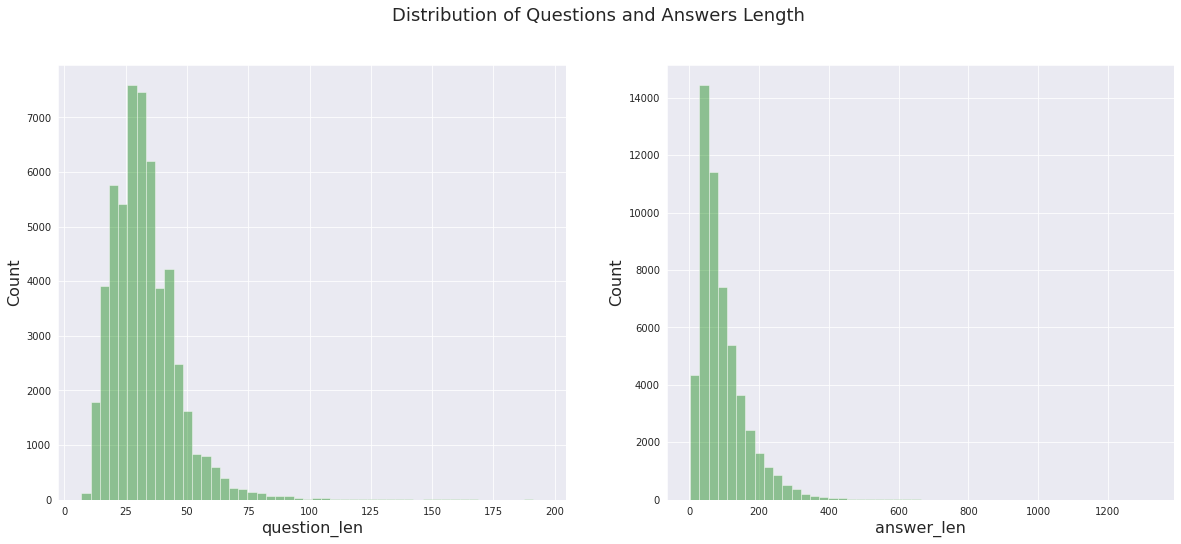

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(20)
fig.set_figheight(8)
fig.suptitle("Distribution of Questions and Answers Length",fontsize=18)
sns.color_palette("rocket_r")
for i, column in enumerate(["question_len","answer_len"]):
    axes[i].set_xlabel(column, fontsize = 16)
    axes[i].set_ylabel(ylabel="Count",fontsize=16)
    
    sns.distplot(qa_df[column], kde=False, ax=axes[i], color="g", bins=50)

**Distribution of Number of Words in Questions and Answers**

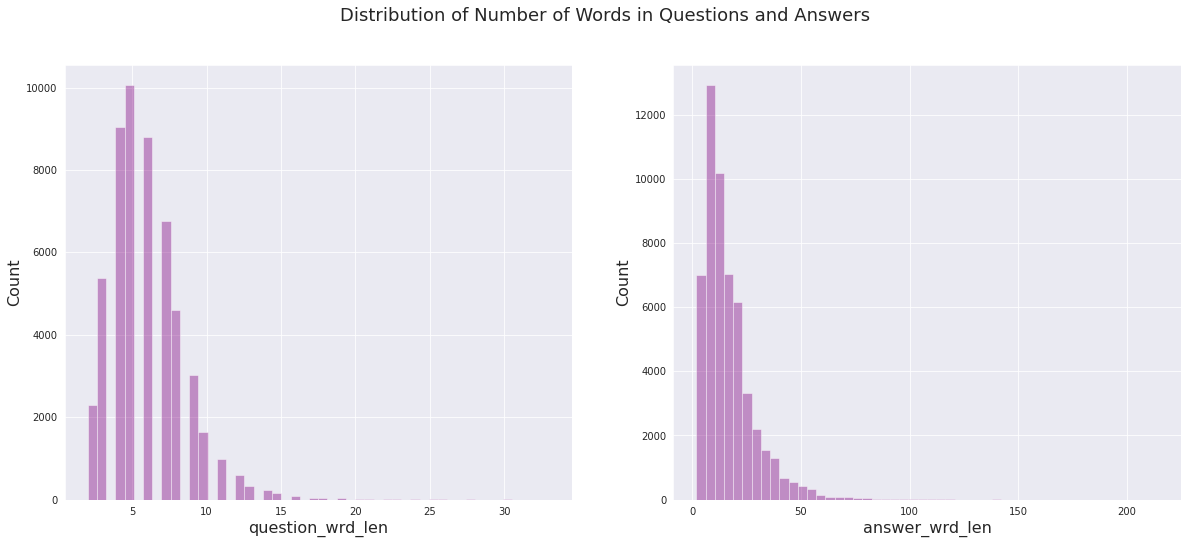

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(20)
fig.set_figheight(8)
fig.suptitle("Distribution of Number of Words in Questions and Answers",fontsize=18)

for i, column in enumerate(["question_wrd_len","answer_wrd_len"]):
    axes[i].set_xlabel(column, fontsize = 16)
    axes[i].set_ylabel(ylabel="Count",fontsize=16)
    
    sns.distplot(qa_df[column], kde=False, ax=axes[i], color="purple", bins=50)   

**Percentage of Multiple Answer Datapoint**

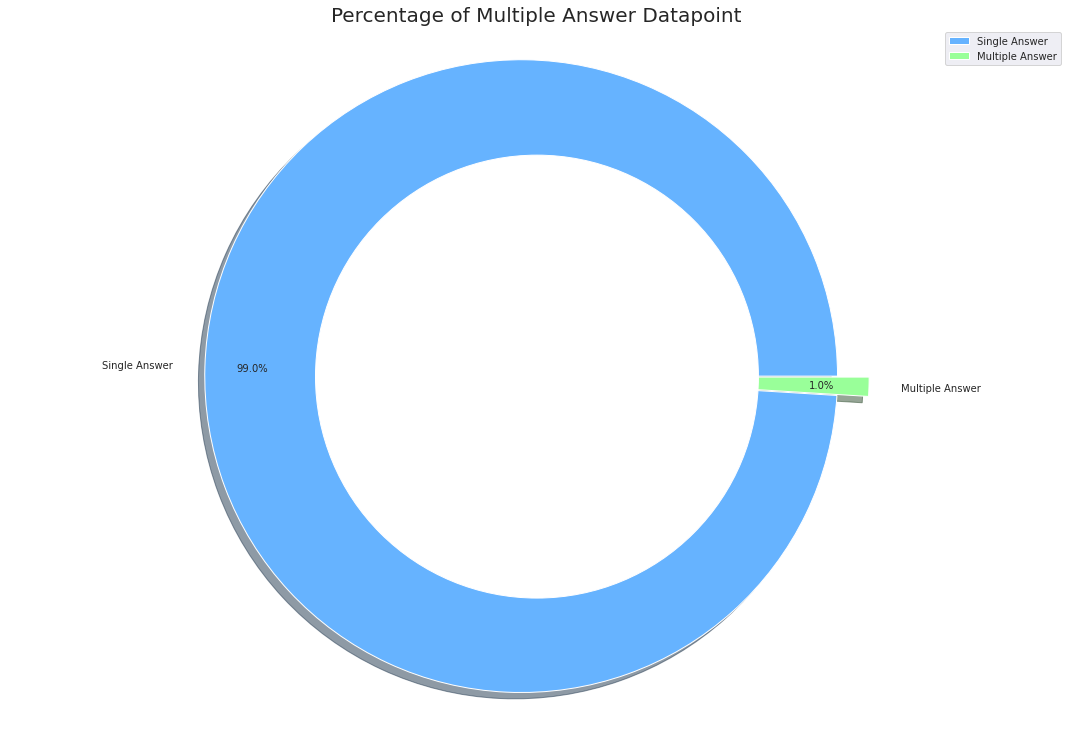

In [19]:
labels = ["Single Answer","Multiple Answer"]
sizes =  [(data_df.shape[0] - multiple_answer_count),multiple_answer_count]
explode = (0.05,0.05)
colors = ["#66b3ff","#99ff99"]

f = plt.figure(figsize=(15,10))
plt.pie(sizes,  labels=labels, colors=colors, shadow=True, autopct="%1.1f%%", explode=explode, pctdistance=0.85)

"""
Draw Circle
"""
centre_circle = plt.Circle((0,0),0.70,fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis("equal")
plt.tight_layout()
plt.title("Percentage of Multiple Answer Datapoint",fontsize=20)
plt.legend(loc="upper right", labels=labels)
plt.show()

**Percentage of Multiple Well-Formed  Answer Datapoint**

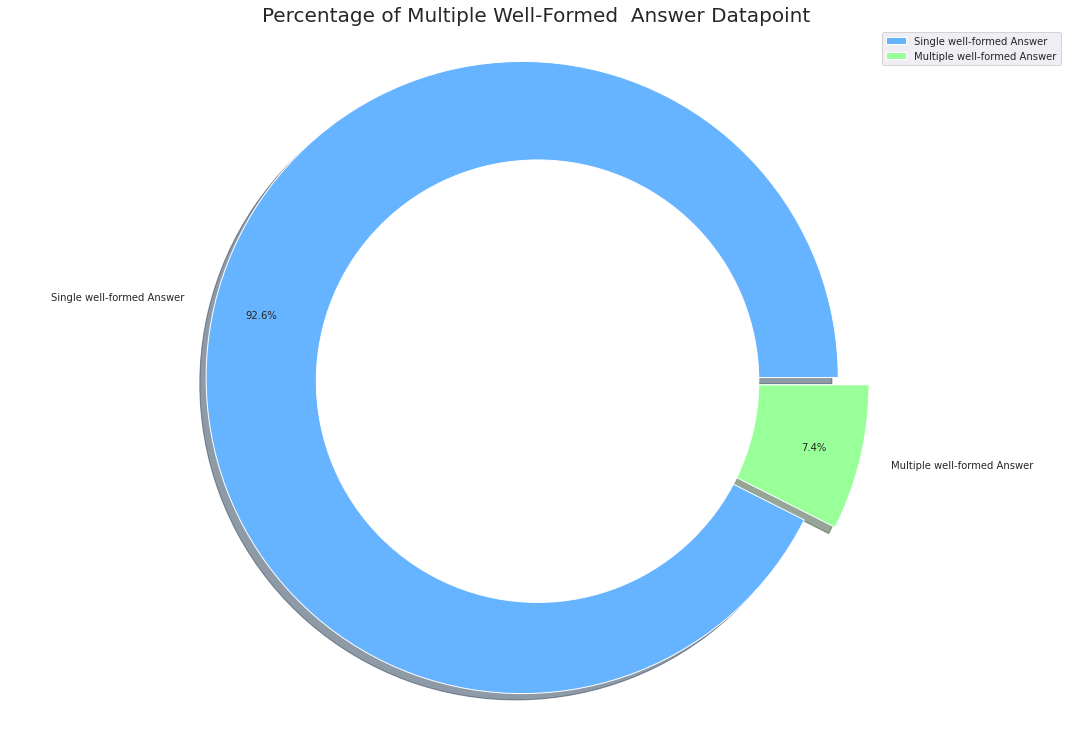

In [20]:
labels = ["Single well-formed Answer","Multiple well-formed Answer"]
sizes =  [(data_df.shape[0] - multiple_well_formed_answer_count),multiple_well_formed_answer_count]
explode = (0.05,0.05)
colors = ["#66b3ff","#99ff99"]

f = plt.figure(figsize=(15,10))
plt.pie(sizes,  labels=labels, colors=colors, shadow=True, autopct="%1.1f%%", explode=explode, pctdistance=0.85)

"""
Draw Circle
"""
centre_circle = plt.Circle((0,0),0.70,fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis("equal")
plt.tight_layout()
plt.title("Percentage of Multiple Well-Formed  Answer Datapoint",fontsize=20)
plt.legend(loc="upper right", labels=labels)
plt.show()

In [24]:
def qa_preprocess(sentence):
    """
    Takes in a string of question and answer, then performs the following:
    1. Remove HTML tag from sentence
    2. Remove URLs from sentence
    3. Make entire sentence lowercase
    4. Split the sentence in words
    5. Remove all punctuation
    6. Remove empty strings from sentence
    7. Remove all stopwords
    8. Returns a list of the cleaned sentence after jioning them back to a sentence
    """
    en_stops = set(stopwords.words("english"))
    
    """
    Removing HTML tag from sentence
    """
    clean = re.compile("<.*?>")
    sentence_without_tag = re.sub(clean, "", sentence) 
    
    
    """
    Removing URLs
    """
    sentence_without_tag_and_url = re.sub(r"http\S+", "", sentence_without_tag)
    
    sentence_without_tag_and_url = re.sub(r"www\S+", "", sentence_without_tag)
    
    """
    Make entire string lowercase
    """
    sentence_lowercase = sentence_without_tag_and_url.lower()
    
    """
    Split string into words
    """
    list_of_words = word_tokenize(sentence_lowercase)
    
    
    """
    Remove punctuation
    Checking characters to see if they are in punctuation
    """

    list_of_words_without_punctuation=["".join(this_char for this_char in this_string if (this_char in string.ascii_lowercase))for this_string in list_of_words]
     
    
    """
    Remove empty strings
    """
    list_of_words_without_punctuation = list(filter(None, list_of_words_without_punctuation))
    
    
    """
    Remove any stopwords
    """
  
    filtered_word_list = [w for w in list_of_words_without_punctuation if w not in en_stops] 
    
    """
    Returns a list of the cleaned sentence after jioning them back to a sentence
    """
    return " ".join(filtered_word_list)

Number of vocabulary : 32301


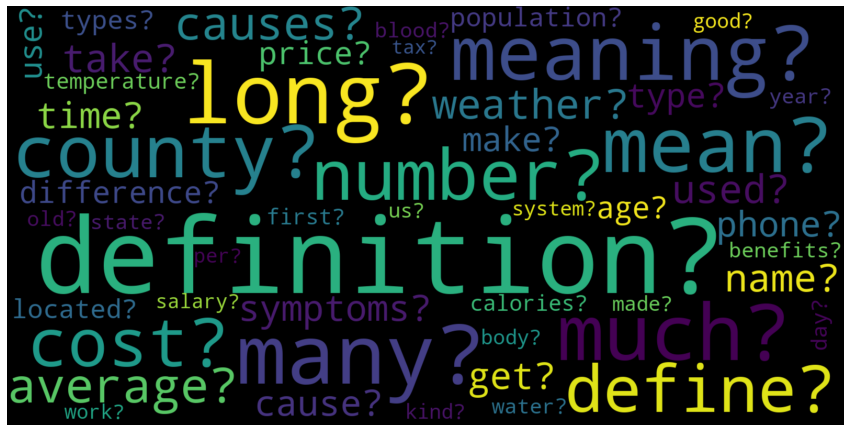

In [25]:
qa_df["clean_question"] = qa_df["question"].apply(qa_preprocess) 

questions = qa_df["clean_question"].str.cat(sep=' ')

"""
Function to split sentence into word
"""
tokens = word_tokenize(questions)
question_tokens = []
for token in tokens:
    question_tokens.append(token+"?")


frequency_distribution = nltk.FreqDist(question_tokens)

def getWordCloud(frequency_dist,color):
    stopWords = set(STOPWORDS)
    wordCloud = WordCloud(background_color=color,
                          stopwords=stopWords,
                          width=1600,
                          height=800,
                          random_state=21,
                          max_words=50,
                          max_font_size=200).generate_from_frequencies(frequency_dist)
    
    plt.figure(figsize=(15, 10))
    plt.axis("off")
    plt.imshow(wordCloud, interpolation="bilinear")

getWordCloud(frequency_distribution,"black")